# Implementation of baseline for DANN
Reference: https://arxiv.org/pdf/1505.07818.pdf

In [1]:
import torch
import torchvision
import torch.nn as nn

In [2]:
torch.__version__

'1.0.0'

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(1)

In [8]:
MODEL_NAME = 'NN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [10]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [14]:
F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)

In [15]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [16]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

In [17]:
svhn_train = datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='../data/', split='test', transform=transform, download=True)

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [18]:
batch_size = 64

In [19]:
svhn_train.data.shape

(73257, 3, 32, 32)

In [20]:
svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [21]:
xe = nn.CrossEntropyLoss()

In [22]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())

In [23]:
max_epoch = 50
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lamda = 0.01

### Training Code



In [26]:
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(mnist_loader)
    return mnist_set.next()

In [28]:
ll_c = []
acc_lst = []

In [29]:
for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)
        
        c = C(F(src))
        Lc = xe(c, labels)
        
        F.zero_grad()
        C.zero_grad()
        
        Lc.backward()
        
        C_opt.step()
        F_opt.step()
        
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, C Loss: {:.4f} ---- {}'.format(epoch, max_epoch, step, Lc.item(), dt))
            ll_c.append(Lc)
        
        if step % 500 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(eval_loader.dataset)
                print('***** Eval Result: {:.4f}, Step: {}'.format(acc, step))
                
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print('***** Test Result: {:.4f}, Step: {}'.format(acc, step))
                acc_lst.append(acc)
                
            F.train()
            C.train()
        step += 1

Epoch: 1/50, Step: 0, C Loss: 2.3101 ---- 05:08:53
***** Eval Result: 0.0759, Step: 0
***** Test Result: 0.0958, Step: 0
Epoch: 1/50, Step: 100, C Loss: 2.1153 ---- 05:09:10
Epoch: 1/50, Step: 200, C Loss: 1.9948 ---- 05:09:16
Epoch: 1/50, Step: 300, C Loss: 1.9285 ---- 05:09:22
Epoch: 1/50, Step: 400, C Loss: 1.6654 ---- 05:09:28
Epoch: 1/50, Step: 500, C Loss: 1.8997 ---- 05:09:34
***** Eval Result: 0.3834, Step: 500
***** Test Result: 0.2259, Step: 500
Epoch: 1/50, Step: 600, C Loss: 1.5960 ---- 05:09:51
Epoch: 1/50, Step: 700, C Loss: 1.6066 ---- 05:09:57
Epoch: 1/50, Step: 800, C Loss: 1.2442 ---- 05:10:03
Epoch: 1/50, Step: 900, C Loss: 1.4055 ---- 05:10:10
Epoch: 1/50, Step: 1000, C Loss: 1.1821 ---- 05:10:16
***** Eval Result: 0.5699, Step: 1000
***** Test Result: 0.2789, Step: 1000
Epoch: 1/50, Step: 1100, C Loss: 1.2983 ---- 05:10:34
Epoch: 2/50, Step: 1200, C Loss: 0.9590 ---- 05:10:40
Epoch: 2/50, Step: 1300, C Loss: 0.8810 ---- 05:10:46
Epoch: 2/50, Step: 1400, C Loss: 0.7

Epoch: 11/50, Step: 11800, C Loss: 0.2066 ---- 05:26:02
Epoch: 11/50, Step: 11900, C Loss: 0.3356 ---- 05:26:08
Epoch: 11/50, Step: 12000, C Loss: 0.2478 ---- 05:26:15
***** Eval Result: 0.9117, Step: 12000
***** Test Result: 0.4888, Step: 12000
Epoch: 11/50, Step: 12100, C Loss: 0.1986 ---- 05:26:33
Epoch: 11/50, Step: 12200, C Loss: 0.1354 ---- 05:26:39
Epoch: 11/50, Step: 12300, C Loss: 0.1408 ---- 05:26:46
Epoch: 11/50, Step: 12400, C Loss: 0.1469 ---- 05:26:52
Epoch: 11/50, Step: 12500, C Loss: 0.2274 ---- 05:26:58
***** Eval Result: 0.9224, Step: 12500
***** Test Result: 0.4555, Step: 12500
Epoch: 12/50, Step: 12600, C Loss: 0.1501 ---- 05:27:16
Epoch: 12/50, Step: 12700, C Loss: 0.2082 ---- 05:27:23
Epoch: 12/50, Step: 12800, C Loss: 0.1478 ---- 05:27:29
Epoch: 12/50, Step: 12900, C Loss: 0.2060 ---- 05:27:36
Epoch: 12/50, Step: 13000, C Loss: 0.1271 ---- 05:27:42
***** Eval Result: 0.9078, Step: 13000
***** Test Result: 0.5270, Step: 13000
Epoch: 12/50, Step: 13100, C Loss: 0.5

Epoch: 21/50, Step: 23300, C Loss: 0.0402 ---- 05:42:48
Epoch: 21/50, Step: 23400, C Loss: 0.1669 ---- 05:42:54
Epoch: 21/50, Step: 23500, C Loss: 0.0607 ---- 05:43:01
***** Eval Result: 0.9317, Step: 23500
***** Test Result: 0.5417, Step: 23500
Epoch: 21/50, Step: 23600, C Loss: 0.0598 ---- 05:43:19
Epoch: 21/50, Step: 23700, C Loss: 0.0679 ---- 05:43:25
Epoch: 21/50, Step: 23800, C Loss: 0.0608 ---- 05:43:31
Epoch: 21/50, Step: 23900, C Loss: 0.1545 ---- 05:43:38
Epoch: 21/50, Step: 24000, C Loss: 0.1994 ---- 05:43:44
***** Eval Result: 0.9174, Step: 24000
***** Test Result: 0.4973, Step: 24000
Epoch: 22/50, Step: 24100, C Loss: 0.0410 ---- 05:44:02
Epoch: 22/50, Step: 24200, C Loss: 0.0265 ---- 05:44:09
Epoch: 22/50, Step: 24300, C Loss: 0.1230 ---- 05:44:15
Epoch: 22/50, Step: 24400, C Loss: 0.0827 ---- 05:44:22
Epoch: 22/50, Step: 24500, C Loss: 0.0252 ---- 05:44:28
***** Eval Result: 0.9072, Step: 24500
***** Test Result: 0.4130, Step: 24500
Epoch: 22/50, Step: 24600, C Loss: 0.0

Epoch: 31/50, Step: 34800, C Loss: 0.0952 ---- 05:59:34
Epoch: 31/50, Step: 34900, C Loss: 0.0284 ---- 05:59:40
Epoch: 31/50, Step: 35000, C Loss: 0.0564 ---- 05:59:47
***** Eval Result: 0.9249, Step: 35000
***** Test Result: 0.4800, Step: 35000
Epoch: 31/50, Step: 35100, C Loss: 0.0548 ---- 06:00:05
Epoch: 31/50, Step: 35200, C Loss: 0.1651 ---- 06:00:11
Epoch: 31/50, Step: 35300, C Loss: 0.0931 ---- 06:00:18
Epoch: 31/50, Step: 35400, C Loss: 0.1654 ---- 06:00:24
Epoch: 32/50, Step: 35500, C Loss: 0.0404 ---- 06:00:30
***** Eval Result: 0.9188, Step: 35500
***** Test Result: 0.4325, Step: 35500
Epoch: 32/50, Step: 35600, C Loss: 0.0614 ---- 06:00:48
Epoch: 32/50, Step: 35700, C Loss: 0.0294 ---- 06:00:55


KeyboardInterrupt: 

## Visualize Sample

In [30]:
import matplotlib.pyplot as plt

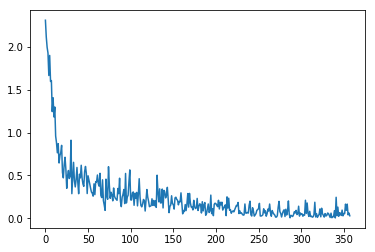

In [31]:
plt.plot(range(len(ll_c)), ll_c)

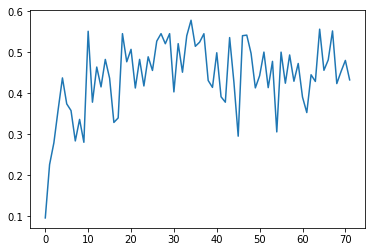

In [32]:
plt.plot(range(len(acc_lst)), acc_lst)

In [33]:
max(acc_lst)

0.578